In [15]:
# ========== Imports ==========
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2      # for grayscale/laplace if you want
import requests
from io import BytesIO


# ========== Helper: isotropic spectrum (correct fftshift version) ==========
def isotropic_spectrum(field_2d):
    """
    Computes isotropic 1D spectrum E(k) from a 2D field using fftshift alignment.
    """
    N = field_2d.shape[0]

    # Remove mean
    f = field_2d - field_2d.mean()

    # Optional Hann window
    win = np.hanning(N)
    W = np.outer(win, win)
    f = f * W

    # FFT
    F = np.fft.fft2(f)
    F = np.fft.fftshift(F)
    P2D = np.abs(F)**2

    # corresponding k-grid
    kfreq = np.fft.fftfreq(N, d=1.0/N)
    kfreq = np.fft.fftshift(kfreq)
    kx, ky = np.meshgrid(kfreq, kfreq, indexing='xy')
    k = np.sqrt(kx**2 + ky**2)

    # Radial bins
    k_flat = k.ravel()
    P_flat = P2D.ravel()

    nbins = N//2
    kmax = k_flat.max()
    bins = np.linspace(0, kmax, nbins+1)
    E = np.zeros(nbins)
    k_center = np.zeros(nbins)

    for i in range(nbins):
        mask = (k_flat >= bins[i]) & (k_flat < bins[i+1])
        if np.any(mask):
            E[i] = P_flat[mask].mean()
            k_center[i] = 0.5*(bins[i] + bins[i+1])

    mask_nonzero = E > 0
    return k_center[mask_nonzero], E[mask_nonzero]


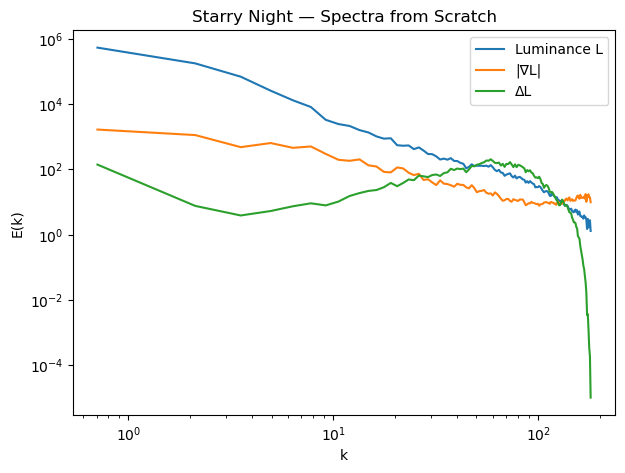

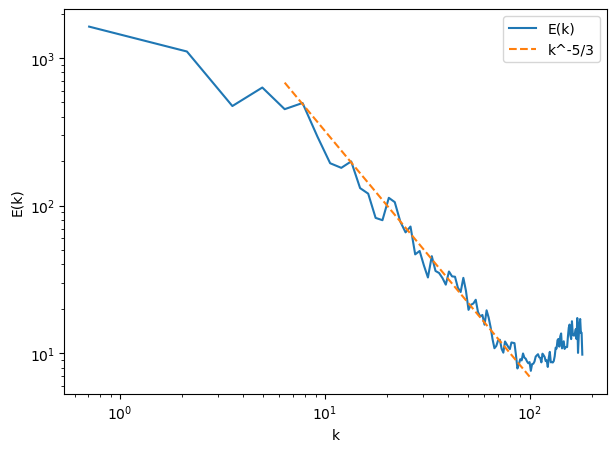

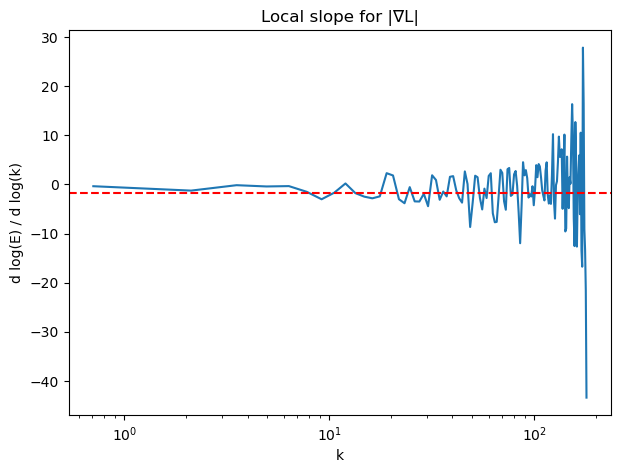

In [17]:
# ========== Load Starry Night (256x256) ==========
# You can replace this with your own file path.
#url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/512px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
img = Image.open("/home/gjayasingh/private/starry_night_512.png").convert("RGB")
img = img.resize((256,256))
img_np = np.array(img)/255.0


# ========== Convert to luminance ==========
# Standard Rec. 709 luminance 
L = 0.2126*img_np[:,:,0] + 0.7152*img_np[:,:,1] + 0.0722*img_np[:,:,2]


# ========== Gradient magnitude ==========
# Use numpy finite differences
Gx = np.gradient(L, axis=1)
Gy = np.gradient(L, axis=0)
grad_mag = np.sqrt(Gx**2 + Gy**2)


# ========== Laplacian ==========
Lxx = np.gradient(Gx, axis=1)
Lyy = np.gradient(Gy, axis=0)
lap = Lxx + Lyy


# ========== Compute spectra ==========
k_L, E_L = isotropic_spectrum(L)
k_G, E_G = isotropic_spectrum(grad_mag)
k_lap, E_lap = isotropic_spectrum(lap)


# ========== Plot spectra ==========
plt.figure(figsize=(7,5))
plt.loglog(k_L,   E_L,   label="Luminance L")
plt.loglog(k_G,   E_G,   label="|∇L|")
plt.loglog(k_lap, E_lap, label="ΔL")
plt.xlabel("k")
plt.ylabel("E(k)")
plt.title("Starry Night — Spectra from Scratch")
plt.legend()
plt.show()


# ========== Overlay k^-5/3 on gradient or Laplacian ==========
def overlay_slope(k, E, kmin, kmax, slope=-5/3, label="k^-5/3"):
    mask = (k > kmin) & (k < kmax)
    logE_mid = np.log(E[mask]).mean()
    logk_mid = np.log(k[mask]).mean()
    intercept = logE_mid - slope*logk_mid

    plt.figure(figsize=(7,5))
    plt.loglog(k, E, label="E(k)")
    plt.loglog(k[mask],
               np.exp(intercept)*k[mask]**slope,
               "--", label=label)
    plt.xlabel("k"); plt.ylabel("E(k)")
    plt.legend(); plt.show()

# Try this on gradient magnitude (usually shows -5/3-like region)
overlay_slope(k_G, E_G, kmin=5, kmax=100)


# ========== Local slope diagnostic ==========
def local_slope(k, E):
    return np.gradient(np.log(E), np.log(k))

ls_G = local_slope(k_G, E_G)

plt.figure(figsize=(7,5))
plt.plot(k_G, ls_G)
plt.axhline(-5/3, color="r", linestyle="--")
plt.xscale('log')
plt.xlabel("k")
plt.ylabel("d log(E) / d log(k)")
plt.title("Local slope for |∇L|")
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

import torch
from torch import nn
import torch.nn.functional as F


In [19]:
def get_mgrid(sidelen, dim=2):
    """Coordinates in [-1,1]^dim on a sidelen^2 grid."""
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    return mgrid.reshape(-1, dim)

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30.0):
        super().__init__()
        self.in_features = in_features
        self.is_first = is_first
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                bound = np.sqrt(6 / self.in_features) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers,
                 out_features, first_omega_0=30.0, hidden_omega_0=30.0,
                 outermost_linear=True):
        super().__init__()
        net = []

        net.append(
            SineLayer(in_features, hidden_features,
                      is_first=True, omega_0=first_omega_0)
        )

        for _ in range(hidden_layers):
            net.append(
                SineLayer(hidden_features, hidden_features,
                          is_first=False, omega_0=hidden_omega_0)
            )

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                bound = np.sqrt(6 / hidden_features) / hidden_omega_0
                final_linear.weight.uniform_(-bound, bound)
            net.append(final_linear)
        else:
            net.append(
                SineLayer(hidden_features, out_features,
                          is_first=False, omega_0=hidden_omega_0)
            )

        self.net = nn.Sequential(*net)

    def forward(self, coords):
        return self.net(coords)


In [20]:
def isotropic_spectrum(field_2d):
    """
    Compute isotropic 1D spectrum E(k) from a 2D field using fftshift.
    """
    N = field_2d.shape[0]
    f = field_2d - field_2d.mean()

    # Hann window – helps edge artefacts
    win = np.hanning(N)
    W = np.outer(win, win)
    f = f * W

    F = np.fft.fft2(f)
    F = np.fft.fftshift(F)
    P2D = np.abs(F)**2

    kfreq = np.fft.fftfreq(N, d=1.0/N)
    kfreq = np.fft.fftshift(kfreq)
    kx, ky = np.meshgrid(kfreq, kfreq, indexing='xy')
    k = np.sqrt(kx**2 + ky**2)

    k_flat = k.ravel()
    P_flat = P2D.ravel()

    nbins = N // 2
    kmax = k_flat.max()
    bins = np.linspace(0, kmax, nbins + 1)

    E = np.zeros(nbins)
    k_center = np.zeros(nbins)

    for i in range(nbins):
        m = (k_flat >= bins[i]) & (k_flat < bins[i+1])
        if np.any(m):
            E[i] = P_flat[m].mean()
            k_center[i] = 0.5*(bins[i] + bins[i+1])

    m = E > 0
    return k_center[m], E[m]


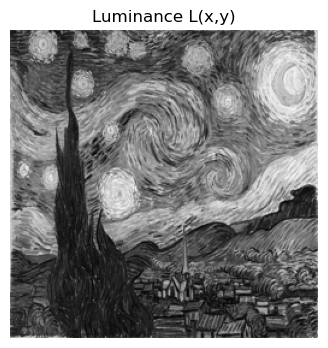

In [23]:
# Download a 512px version and downsample to 256x256
#url = ("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/"
       #"Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/512px-"
       #"Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")

img = Image.open("/home/gjayasingh/private/starry_night_512.png").convert("RGB")
img = img.resize((256, 256))
img_np = np.array(img, dtype=np.float32) / 255.0     # [256,256,3]

# luminance
L = 0.2126*img_np[...,0] + 0.7152*img_np[...,1] + 0.0722*img_np[...,2]  # [256,256]

plt.figure(figsize=(4,4))
plt.imshow(L, cmap="gray")
plt.axis("off")
plt.title("Luminance L(x,y)")
plt.show()

N = L.shape[0]


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# coords in [-1,1]^2
coords = get_mgrid(N, 2).to(device)          # [N^2, 2]

# ground truth luminance as tensor in [-1,1] (optional re-scaling)
L_torch = torch.from_numpy(L.reshape(-1,1)).to(device)

# (optional) rescale to [-1,1] to help SIREN
L_min, L_max = L_torch.min(), L_torch.max()
L_norm = 2 * (L_torch - L_min) / (L_max - L_min) - 1.0

# model
img_siren = Siren(
    in_features=2,
    hidden_features=256,
    hidden_layers=3,
    out_features=1,
    outermost_linear=True,
    first_omega_0=30.0,
    hidden_omega_0=30.0
).to(device)

optim = torch.optim.Adam(img_siren.parameters(), lr=1e-4)

total_steps = 2000
for step in range(1, total_steps+1):
    optim.zero_grad()
    pred = img_siren(coords)      # [N^2,1]
    loss = F.mse_loss(pred, L_norm)
    loss.backward()
    optim.step()

    if step % 200 == 0 or step == 1:
        print(f"step {step:4d} | loss {loss.item():.6e}")


device: cuda
step    1 | loss 2.133216e-01
step  200 | loss 1.893307e-02
step  400 | loss 4.985834e-03
step  600 | loss 1.117542e-03
step  800 | loss 3.531388e-04
step 1000 | loss 1.577818e-04
step 1200 | loss 9.409746e-05
step 1400 | loss 6.709702e-05
step 1600 | loss 8.588859e-05
step 1800 | loss 4.245692e-05
step 2000 | loss 4.032359e-05


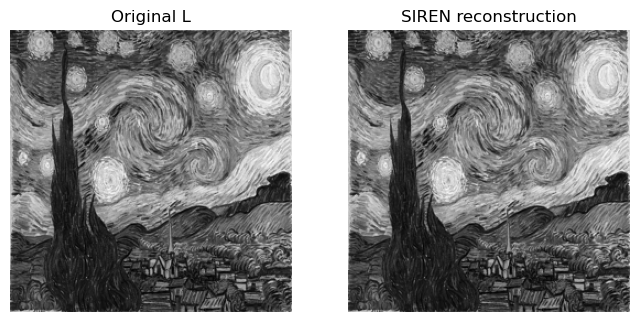

In [25]:
img_siren.eval()
with torch.no_grad():
    pred = img_siren(coords)      # [N^2,1]
L_pred_norm = pred.view(N, N).cpu().numpy()

# back to [0,1] for visualization
L_pred = (L_pred_norm + 1.0)/2.0
L_pred = L_min.cpu().item() + (L_max - L_min).cpu().item() * L_pred

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(L, cmap="gray")
plt.title("Original L")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(L_pred, cmap="gray")
plt.title("SIREN reconstruction")
plt.axis("off")
plt.show()


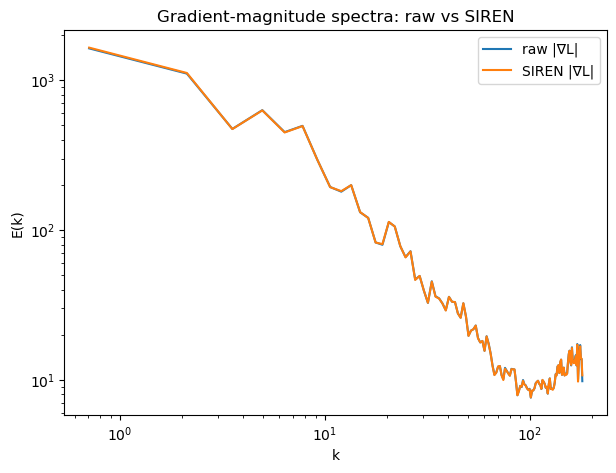

In [26]:
# ---------- raw image gradient magnitude ----------
Gx_raw = np.gradient(L, axis=1)
Gy_raw = np.gradient(L, axis=0)
grad_mag_raw = np.sqrt(Gx_raw**2 + Gy_raw**2)

# ---------- SIREN reconstruction gradient magnitude ----------
Gx_siren = np.gradient(L_pred, axis=1)
Gy_siren = np.gradient(L_pred, axis=0)
grad_mag_siren = np.sqrt(Gx_siren**2 + Gy_siren**2)

# ---------- spectra ----------
k_raw,   E_raw   = isotropic_spectrum(grad_mag_raw)
k_siren, E_siren = isotropic_spectrum(grad_mag_siren)

plt.figure(figsize=(7,5))
plt.loglog(k_raw,   E_raw,   label="raw |∇L|")
plt.loglog(k_siren, E_siren, label="SIREN |∇L|")
plt.xlabel("k"); plt.ylabel("E(k)")
plt.title("Gradient-magnitude spectra: raw vs SIREN")
plt.legend()
plt.show()


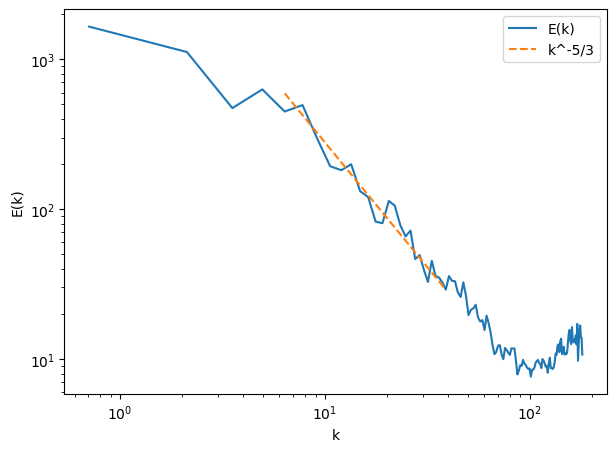

In [27]:
def overlay_slope(k, E, kmin, kmax, slope=-5/3, label="k^-5/3"):
    m = (k > kmin) & (k < kmax)
    logE_mid = np.log(E[m]).mean()
    logk_mid = np.log(k[m]).mean()
    intercept = logE_mid - slope * logk_mid

    plt.figure(figsize=(7,5))
    plt.loglog(k, E, label="E(k)")
    plt.loglog(k[m],
               np.exp(intercept)*k[m]**slope,
               "--", label=label)
    plt.xlabel("k"); plt.ylabel("E(k)")
    plt.legend(); plt.show()

overlay_slope(k_siren, E_siren, kmin=5, kmax=40)


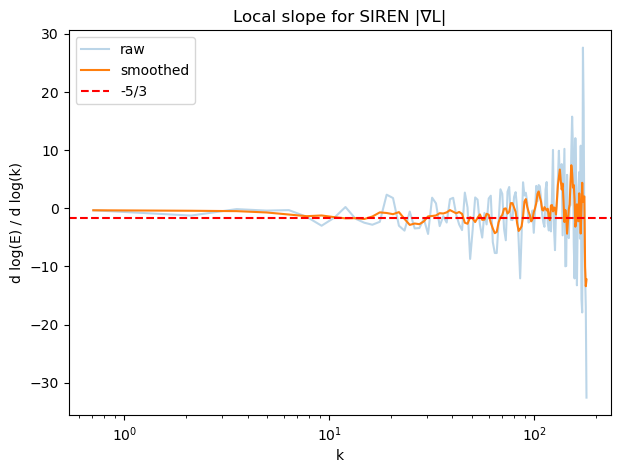

In [28]:
def local_slope(k, E):
    return np.gradient(np.log(E), np.log(k))

ls = local_slope(k_siren, E_siren)
window = 5
ls_smooth = np.convolve(ls, np.ones(window)/window, mode="same")

plt.figure(figsize=(7,5))
plt.plot(k_siren, ls, alpha=0.3, label="raw")
plt.plot(k_siren, ls_smooth, label="smoothed")
plt.axhline(-5/3, color="r", linestyle="--", label="-5/3")
plt.xscale("log")
plt.xlabel("k"); plt.ylabel("d log(E) / d log(k)")
plt.title("Local slope for SIREN |∇L|")
plt.legend()
plt.show()
